# Principle Component Analysis (PCA)

 Recall that  a data matrix $X$ consists of $N$ rows and $d$ columns (i.e. each of the $N$ rows is an example, where each example contains $d$ features: $x^{(i)} \in \mathbb{R}^d$.)
 
 $$ X=\left[\begin{matrix}
x^{(1)}_1 & x^{(1)}_2& \cdots & x^{(1)}_d\\
x^{(2)}_1 & x^{(2)}_2& \cdots & x^{(2)}_d\\
\vdots & \vdots & \cdots & \vdots \\
x^{(N)}_1 & x^{(N)}_2& \cdots & x^{(N)}_d\\
 \end{matrix}\right]$$ 
 
 PCA asks the question, "How can we *best* represent the information in $X$ in a lower dimensional subspace?"$\:$ In other words, how can we find $k<d$ (new) features that *best* caputures the information in the orginal data by keeping as much variability in the dataset. (The features should be uncorrelated to provide variablity not given by the other features.)

We start by centering the data.  Then we find the best $k$ new uncorrelated features $v_1 v_2 ... v_k$ that maximize the variance.  These new features are called the top $k$ *principle components* of $X$.

The intuition behind the above objective function can be visualized with the following 2D data points $x^{(i)}$ in $R^2$. 

<img src="max var and points.png" height="200" width="600">

---
In this notebook, we shall extract the principle components ( $v_1, v_2, ..., v_k$ ) of a data matrix, $X$, through the following 3 techniques:
1. through the **Singular Value Decomposition (SVD)** of $X$
2. by computating the **eigenvectors of the covariance matrix** of $X$, i.e,  $\frac{1}{N}X^{T}X$, and
3. **Power Iteration method** of computing eigenvectors
---

Let's first import the necessary packages

In [1]:
import numpy as np
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d import proj3d
from matplotlib.patches import FancyArrowPatch

The following toy example is from from http://web.stanford.edu/class/cs246/slides/06-dim_red.pdf

Consider the following data matrix, $X$, 

<img src="images/data_matrix.png" height="300" width="300" align='center'>

- Here, each row corresponds to the ratings submitted by a single user on a scale of $1$ to $5$ for each of the movies. If a user hasn't submitted a movie rating, then rating is then marked by a zero. 
- By a visual inspection, we see that the movies are either **sci-fi** or **romance**
- The individual movies that we start with can be considered 5 different dimensions, whereas when we group them into two genres (sci-fi or romance), these may be seen as a compressed representation of our data.
- So the natural question is, can we it possible to gain compressed representation of our data matrix to highlight this distinction in our data?

Time for some PCA...



## Step 1:  Getting, understanding, and preprocessing the dataset


In [2]:
X = np.array([[1, 1, 1, 0, 0],
              [3, 3, 3, 0, 0],
              [4, 4, 4, 0, 0],
              [5, 5, 5, 0, 0],
              [0, 2, 0, 4, 4],
              [0, 0, 0, 5, 5],
              [0, 1, 0, 2, 2]])

num_users = 7
num_movies = 5

Normally we wouldn't know that the movie ratings are based on **sci-fi** or **romance**.  But since we know the structure, we can plot the points (thanks to our TA Rohan) to see the structure we want PCA to uncover.

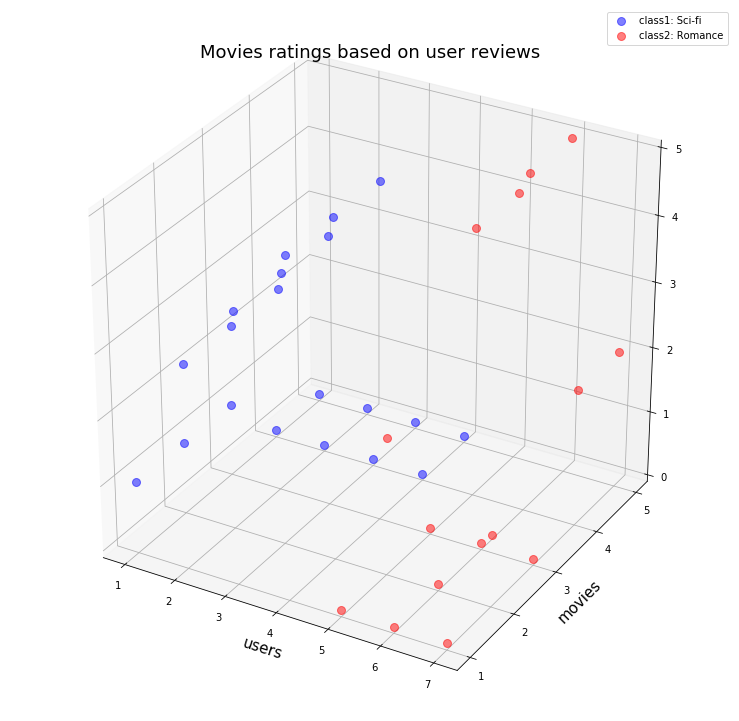

In [3]:
users = np.array( [[i]*num_movies for i in range(1, num_users+1) ]).flatten()
movie = np.array( [[i] for i in range(1, num_movies+1)]*num_users ).flatten()
reviews = X.flatten()
# print("users   ->", users)
# print("movie   ->", movie)
# print("reviews ->", reviews)
fig = plt.figure(figsize=(13,13))
ax = fig.add_subplot(111, projection='3d')
plt.rcParams['legend.fontsize'] = 10   

ax.plot(users[:20], movie[:20], reviews[:20], 'o', markersize=8, color='blue',  alpha=0.5, label='class1: Sci-fi')
ax.plot(users[20:], movie[20:], reviews[20:], 'o', markersize=8, color='red',   alpha=0.5, label='class2: Romance')

plt.xticks(ticks=[1, 2, 3, 4, 5, 6, 7])
plt.yticks(ticks=[1, 2, 3, 4, 5])
plt.title('Movies ratings based on user reviews', fontsize=18)
plt.xlabel("users", fontsize=15)
plt.ylabel("movies", fontsize=15)
ax.legend(loc='upper right')

plt.show()


### Preprocessing step need for PCA: centering the dataset

In [4]:
Xmean = X.mean(axis=0)
X_centered = X-Xmean
print(X_centered)

[[-0.85714286 -1.28571429 -0.85714286 -1.57142857 -1.57142857]
 [ 1.14285714  0.71428571  1.14285714 -1.57142857 -1.57142857]
 [ 2.14285714  1.71428571  2.14285714 -1.57142857 -1.57142857]
 [ 3.14285714  2.71428571  3.14285714 -1.57142857 -1.57142857]
 [-1.85714286 -0.28571429 -1.85714286  2.42857143  2.42857143]
 [-1.85714286 -2.28571429 -1.85714286  3.42857143  3.42857143]
 [-1.85714286 -1.28571429 -1.85714286  0.42857143  0.42857143]]


---
## Step 2. Implementing PCA using Singular Value Decomposition (SVD)

We start with the simplest and most straightforward strategy first - **Singular Value Decomposition**. <br>

From our Matrix theory, we know that ever matrix out there can we decomposed into a multiplication of 3 matrices (image is from Tim Roughgarden):

$$ X = U S  V^T$$

<img src="images/SVD.png" height="500" width="500">

In class we proved that we can use the SVD to factorize $X^TX=(USV^T)^T(USV^T)=VS^2V^T$.

The principal components of the matrix $A=X^TX$, lie in the rows of matrix $V^T$. Therefore, by selecting the first $k$ columns of $V$, we end up selecting $v_1, v_2, ..., v_k$ vectors.

In [5]:
u, s, vT = np.linalg.svd(X_centered) #note that s contains only the diagonal elements

print("U.shape, S.shape, V.T.shape ->", u.shape, s.shape, vT.shape, end="\n\n")

print("U =",np.around(u, decimals=3), sep="\n", end="\n\n")

print("S =",np.around(s, decimals=3), sep="\n", end="\n\n")

print("V.T =",np.around(vT, decimals=3), sep="\n", end="\n\n")

U.shape, S.shape, V.T.shape -> (7, 7) (5,) (5, 5)

U =
[[ 0.014 -0.691  0.158  0.343 -0.51   0.059 -0.341]
 [ 0.265 -0.142  0.077 -0.059 -0.184 -0.839  0.403]
 [ 0.39   0.133  0.036 -0.596 -0.595  0.329  0.11 ]
 [ 0.516  0.408 -0.004  0.702 -0.158  0.155  0.16 ]
 [-0.388  0.286 -0.686  0.091 -0.47  -0.211 -0.154]
 [-0.546  0.347  0.662  0.099 -0.325 -0.028  0.162]
 [-0.25  -0.34  -0.244  0.115 -0.036  0.339  0.796]]

S =
[10.492  4.09   1.324  0.     0.   ]

V.T =
[[ 0.471  0.374  0.471 -0.456 -0.456]
 [ 0.356  0.412  0.356  0.537  0.537]
 [ 0.389 -0.831  0.389  0.061  0.061]
 [-0.038  0.     0.038 -0.706  0.706]
 [ 0.706 -0.    -0.706 -0.038  0.038]]



### Selecting the right number $k$ of principal components

The best way to select $k$ is by cross validation. 

However, we can  calculate how much of the variance of the original dataset was maintainded after projecting to $k$ dimensions.


Remember  $X^TX$ can be factorized into $X^TX=VDV^T$ where 
$D=\left[\begin{matrix}
\lambda_1&0&\cdots & 0 \\
0&\lambda_2&\cdots & 0 \\
\vdots & \vdots & & \vdots \\
0&0&\cdots &\lambda_d
\end{matrix}\right]$

The amount of variance we maintain by selelcting the top $k$ princple components is $\frac{\sum_{i=1}^k\lambda_i}{\sum_{i=1}^d\lambda_i}$


Let's plot the singlar values for the $D$ matrix.

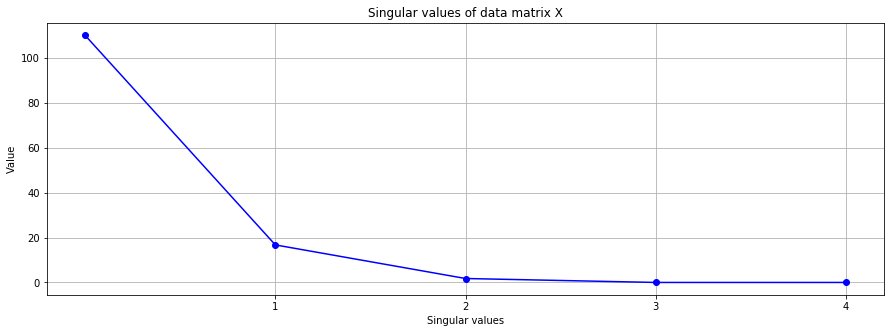

In [6]:
d = s*s
plt.figure(figsize=(15, 5))
plt.plot(d, 'bo-')
plt.ylabel("Value")
plt.xlabel("Singular values")
plt.title("Singular values of data matrix X")
plt.xticks([i+1 for i in range(len(d)-1)])
plt.grid()

Notice, that values that follow the first two singular values diminish to zero. <br>

Hence, we may be able to represent our data matrix fairly well with just the first to principal components.

---

### Obtaining our compressed data representation : $X_{PCA}$

In [7]:
X_pca = np.matmul(X, np.transpose(vT[:2, :]))
print(np.around(X_pca, decimals=3))

[[ 1.317  1.124]
 [ 3.95   3.372]
 [ 5.267  4.496]
 [ 6.583  5.62 ]
 [-2.9    5.121]
 [-4.559  5.37 ]
 [-1.45   2.56 ]]


Lets visualize what just happened.

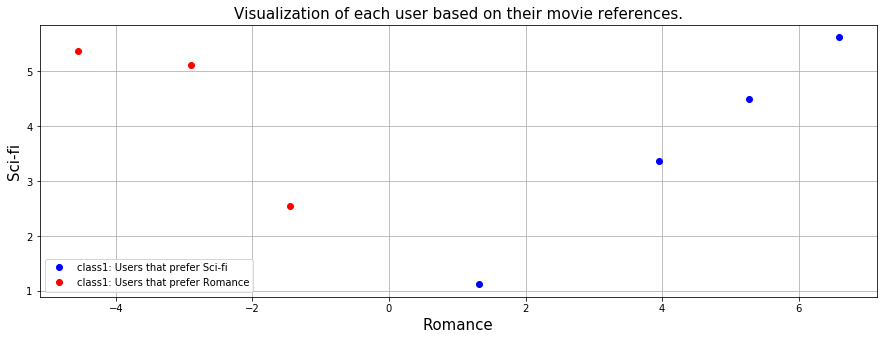

In [8]:
plt.figure(figsize=(15,5))
plt.title("Visualization of each user based on their movie references.", fontsize=15)
plt.plot(X_pca[:4,0], X_pca[:4,1], 'bo', label='class1: Users that prefer Sci-fi')
plt.plot(X_pca[4:,0], X_pca[4:,1], 'ro', label='class1: Users that prefer Romance')
plt.ylabel('Sci-fi', fontsize=15)
plt.xlabel('Romance', fontsize=15)
plt.legend(loc='lower left')
plt.grid()

And there we have it. <br>

- The data has been projected into $2D$ space wherein each of the users have been positioned in space based on their movie preferences. 
- Each of the dimensions now capture the degree to a user prefers Sci-fi or Romance.

- The compressed data representation of $X$ is now $X_{PCA}$. 
- $X_{PCA}$ can now be used to do further machine learning, such as clustering, binary classification, and so on.

---
## Alternative implementation: Directly computing  V and D from $X^TX$

The covariance matrix data matrix, $X$, can be computed as  $\frac{1}{N}X^TX$. <br>
If $X$ is our data matrix comprising of $d$ features. Then $X^TX$ is a $(d \times d)$ symmetrix matrix wherein each entry at location **ij** corresponds to the scalar projection of **feature i** with **feature j**.

In [9]:
A = np.matmul(np.transpose(X_centered), X_centered) # This could have been writen as A = np.dot(X_centered.T,X_centered) 

print(np.around(A, decimals = 3))


[[ 26.857  21.286  26.857 -20.429 -20.429]
 [ 21.286  19.429  21.286 -15.143 -15.143]
 [ 26.857  21.286  26.857 -20.429 -20.429]
 [-20.429 -15.143 -20.429  27.714  27.714]
 [-20.429 -15.143 -20.429  27.714  27.714]]


Now we compute $V$ (aka as the eigenvectors), and the diagonal elements of $D$ (aka eigenvalues) from $A=X^TX=V D V^T$

In [10]:
eig_values, eig_vectors = np.linalg.eig(A)# Calling a function to compute V and D

print("V (Eigen-vectors) = ")
print(np.around(eig_vectors, decimals=3)) #printing V upto 3 decimal places
print()
print("diagonal elements of D (Eigen-values) = ")
print(np.around(eig_values, decimals=3)) #printing the diagonal elements in D upto 3 decimal places
print()
print("sqrt(Eigen-values) = ")
print(np.around(np.sqrt(np.abs(eig_values)), decimals=3))

V (Eigen-vectors) = 
[[-0.471 -0.356  0.389 -0.009  0.689]
 [-0.374 -0.412 -0.831 -0.     0.   ]
 [-0.471 -0.356  0.389  0.009 -0.689]
 [ 0.456 -0.537  0.061 -0.707 -0.16 ]
 [ 0.456 -0.537  0.061  0.707  0.16 ]]

diagonal elements of D (Eigen-values) = 
[110.093  16.726   1.753  -0.      0.   ]

sqrt(Eigen-values) = 
[10.492  4.09   1.324  0.     0.   ]


Notice the following:
1. That the **square-root of the eigen-values** of the covariance matrix $X^TX$ correspond exactly the the **singular values** of the data matrix $X$.
2. The **eigen-vectors** of $X^TX$ are exactly the same as the column vectors in the matrix $V$ when we performed SVD on $X$.

Therefore, the same Princpal components of our data matrix $X$, may be extracted via SVD or from $X$'s convariance matrix.

---
## Homework

The code below loads a dataset containing images of faces
and displays some of them. 

Each image is a 62x47 pixel array.
The images are read into a matrix called fea.
The rows of the matrix fea are the images (examples).
The features (columns) are the pixels.
Each example is represented by a vector of real numbers of length 2914,
listing the pixels from left to right, row by row, from top to bottom.




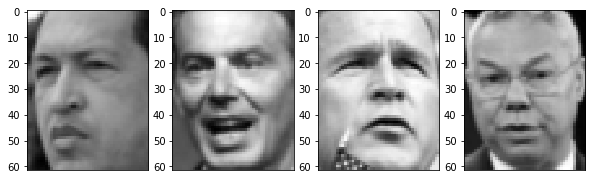

In [11]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd

from sklearn.datasets import fetch_lfw_people
lfw_people = fetch_lfw_people(min_faces_per_person=70)
n_samples, h, w = lfw_people.images.shape
npix = h*w
fea = lfw_people.data

def plt_face(x):
    global h,w
    plt.imshow(x.reshape((h, w)), cmap=plt.cm.gray)
    plt.xticks([])

plt.figure(figsize=(10,20))
nplt = 4
for i in range(nplt):    
    plt.subplot(1,nplt,i+1)
    plt_face(fea[i])

plt.show()



You can display the face corresponding to Example t in the dataset
by executing the following commands:


plt_face(fea[t])

plt.show()

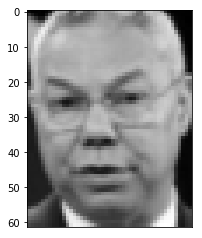

In [26]:
# Display the fourth face in the dataset
plt_face(fea[3])
plt.show()

In [18]:
# Compute the mean of all the examples in the dataset fea.
fea_mean = fea.mean(axis=0)
print("the mean of all the examples in the dataset fea: {}".format(fea_mean))

the mean of all the examples in the dataset fea: [ 91.94698  95.09418 101.15502 ... 117.36201 110.7413  104.42233]


In [17]:
# Do dimensionality reduction with pca.
fea_centered = fea - fea_mean

u, s, vT = np.linalg.svd(fea_centered) #note that s contains only the diagonal elements
print("U.shape, S.shape, V.T.shape ->", u.shape, s.shape, vT.shape, end="\n\n")

fea_pca_5 = np.matmul(fea, np.transpose(vT[:5, :]))

# values of the associated 5 attributes of the fourth image
print("values of the associated 5 attributes of the fourth image: {}".format(np.around(fea_pca_5[3], decimals=3)))

U.shape, S.shape, V.T.shape -> (1288, 1288) (1288,) (2914, 2914)

values of the associated 5 attributes of the fourth image: [6805.36   315.574  171.065 1322.474  772.015]


In [ ]:
# Project the fourth face in the dataset onto the ﬁrst 5 principle components.

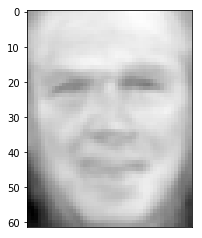

In [42]:
# Project the fourth face back into the original space.
fea_back_5 = np.matmul(fea_pca_5, vT[:5, :])
plt_face(fea_back_5[3])
plt.show()

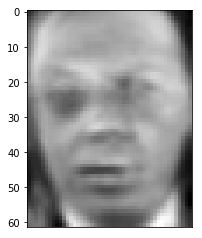

In [40]:
# the ﬁrst 50 principle components.
fea_pca_50 = np.matmul(fea, np.transpose(vT[:50, :]))
fea_back_50 = np.matmul(fea_pca_50, vT[:50, :])
plt_face(fea_back_50[3])
plt.show()